<a href="https://colab.research.google.com/github/yi-juho/-K_MHAS-_HuggingFace_dataset_MultiBERT_shared/blob/main/CoLA_Document_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Document Classification BERT [CoLA]

*   항목 추가
*   항목 추가




In [1]:
%mkdir model

mkdir: cannot create directory ‘model’: File exists


### cordic

In [36]:
import numpy as np

def top_1200_input(attention_scores, dim=-1):
    """
    1200개의 attention_scores를 120개의 리스트로 나누어 각 리스트를 top 함수에 전달
    """
    chunk_size = len(attention_scores) // dim
    data_list = [attention_scores[i * chunk_size:(i + 1) * chunk_size] for i in range(120)]

    # 120개의 결과 리스트 생성
    result_arrays = []

    # 각 10개씩 top 함수에 전달
    for i in range(120):
        result = top(*data_list[i])  # 리스트를 개별 인자로 풀어서 전달
        result_arrays.append(result)  # 결과 저장

    return result_arrays



def float_to_fixed_point(value, int_bits=7, frac_bits=13):
    """
    실수를 32비트 Fixed-Point 바이너리로 변환하는 함수.
    - 31~20 비트: 항상 0 (상위 12비트)
    - 19~13 비트: 정수부 (7비트, Signed, 2의 보수)
    - 12~0 비트: 소수부 (13비트, 항상 양수)

    정수부는 내림하여 변환하고, 소수부를 정확한 2진 변환 방식으로 변환.
    """
    max_frac_value = 2**frac_bits  # 13비트 소수부 정밀도 (8192)

    # ✅ 1. 정수부와 소수부 정확하게 분리 (내림 적용)
    int_part = np.floor(value).astype(int)
    frac_part = abs(value - int_part)  # 소수부 절댓값 유지

    # ✅ 2. 정수부(7비트) 변환 (2의 보수 변환)
    if int_part < 0:
        int_binary = format((1 << int_bits) + int_part, f'0{int_bits}b')  # 7비트 2의 보수 변환
    else:
        int_binary = format(int_part, f'0{int_bits}b')  # 7비트 양수 표현

    # ✅ 3. 앞 12비트는 항상 0으로 유지
    int_binary = "0" * 12 + int_binary

    # ✅ 4. 소수부 변환 (부동소수점 오차 최소화)
    frac_binary = ""
    frac_value = frac_part  # 소수부 값 유지
    for _ in range(frac_bits):  # 13비트 반복
        frac_value *= 2
        if frac_value >= 1:
            frac_binary += "1"
            frac_value -= 1
        else:
            frac_binary += "0"

    # ✅ 5. 최종 32비트 바이너리 생성
    fixed_binary = int_binary + frac_binary
    fixed_binary_int = int(fixed_binary, 2)
    lower_20_bits = fixed_binary_int & 0xFFFFF
    return lower_20_bits

def binary_to_decimal(binary_str):
    # 16비트 중 앞 3비트는 정수부, 뒤 13비트는 소수부
    int_part = int(binary_str[:3], 2)  # 정수부
    frac_part = int(binary_str[3:], 2) / (2 ** 13)  # 소수부를 2^13으로 나눔
    return int_part + frac_part  # 정수부와 소수부 합산

def hex_to_binary(hex_str):
    """
    16비트 헥스 값을 16비트 바이너리 문자열로 변환하는 함수

    :param hex_str: 변환할 16비트 헥스 값 (예: "1A2F" 또는 0x1A2F)
    :return: 16비트 바이너리 문자열 (예: "0001101000101111")
    """
    # hex_str가 정수형일 경우 문자열로 변환
    if isinstance(hex_str, int):
        hex_str = format(hex_str, 'X')  # 16진수 대문자로 변환

    # 16진수를 10진수로 변환 후, 16비트 이진수로 변환
    binary_str = bin(int(hex_str, 16))[2:].zfill(16)
    return binary_str

# 테스트 예제


# 테스트 예제


def top(data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10) : #20bit data

    data_11 = float_to_fixed_point(data_1)
    data_22 = float_to_fixed_point(data_2)
    data_33 = float_to_fixed_point(data_3)
    data_44 = float_to_fixed_point(data_4)
    data_55 = float_to_fixed_point(data_5)
    data_66 = float_to_fixed_point(data_6)
    data_77 = float_to_fixed_point(data_7)
    data_88 = float_to_fixed_point(data_8)
    data_99 = float_to_fixed_point(data_9)
    data_1010 = float_to_fixed_point(data_10)


    data_list = [data_11, data_22, data_33, data_44, data_55, data_66, data_77, data_88, data_99, data_1010]
    #data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    int_list = [0] * 10 #exp_int input
    exp_int_output = [0]*10 #exp_int output
    fraction_list=[0]*10 #cordic_exu input
    exp_fraction_output = [0]*10 #cordic_exu output
    exp_whole=[0]*10 #cordic_exu +cordic_int
    exp_trunc=[0]*10
    exp_accum_input=[0]*10 # accumulator input  (exponential)
    exp_accum_output=[0]*1
    x_divider = [0] * 10 #cordic diu input
    y_dividend = [0] * 10 #cordic diu input
    data_out = [0] * 10
    binary_values = [0] * 10
    int_values = [0.0] * 10
    for i in range(10):  # int part
        int_list[i] = data_list[i] >> 13
    exp_int_output[0], exp_int_output[1], exp_int_output[2], exp_int_output[3], exp_int_output[4], exp_int_output[5], exp_int_output[6], exp_int_output[7], exp_int_output[8], exp_int_output[9]=exp_int(int_list[0], int_list[1], int_list[2], int_list[3], int_list[4], int_list[5], int_list[6], int_list[7], int_list[8], int_list[9])

    for i in range(10):  # fraction part
        fraction_list[i] = (data_list[i] & 0x1FFF) << 1  # 하위 13비트를 가져오고, 뒤에 0을 추가
    exp_fraction_output[0], exp_fraction_output[1], exp_fraction_output[2], exp_fraction_output[3], exp_fraction_output[4], exp_fraction_output[5], exp_fraction_output[6], exp_fraction_output[7], exp_fraction_output[8], exp_fraction_output[9] = cordic_exu(fraction_list[0], fraction_list[1], fraction_list[2], fraction_list[3], fraction_list[4], fraction_list[5], fraction_list[6], fraction_list[7], fraction_list[8], fraction_list[9])


    for i in range(10):
       exp_whole[i] = exp_int_output[i] * exp_fraction_output[i]

    for i in range(10):
       exp_trunc[i] = (exp_whole[i] >> 14) & 0xFFFFF  # 33~14 비트를 추출 (20비트)
    for i in range(10):
       exp_accum_input[i] = (exp_trunc[i] >> 4) & 0xFFFF

    exp_accum_output[0] = cordic_accumulator(exp_accum_input[0],exp_accum_input[1],exp_accum_input[2],exp_accum_input[3],exp_accum_input[4],exp_accum_input[5],exp_accum_input[6],exp_accum_input[7],exp_accum_input[8],exp_accum_input[9])



    # denominator_sf[i]에서 18~4 비트 추출 후, 앞에 0을 붙여서 x_divider에 할당
    x_divider[0] = (exp_accum_output[0] >> 4) & 0x7FFF  # 18~4 비트를 추출 (15비트)

    for i in range(10):
    # numerator_sf[i]에서 15~4 비트 추출 후, 앞에 4개의 0을 붙여서 y_dividend에 할당
        y_dividend[i] = (exp_accum_input[i] >> 4)  # 15~4 비트를 추출 (12비트)

    data_out[0],data_out[1],data_out[2],data_out[3],data_out[4],data_out[5],data_out[6],data_out[7],data_out[8],data_out[9], = cordic_diu (x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],y_dividend[0],y_dividend[1],y_dividend[2],y_dividend[3],y_dividend[4],y_dividend[5],y_dividend[6],y_dividend[7],y_dividend[8],y_dividend[9])

    for i in range(10):
        binary_values[i] = hex_to_binary(data_out[i])
       # print(binary_values[i])

    for i in range(10):
        int_values[i] = binary_to_decimal(binary_values[i])
        #print(int_values[i])

    return int_values[0],int_values[1],int_values[2],int_values[3],int_values[4],int_values[5],int_values[6],int_values[7],int_values[8],int_values[9]
   #return int_values

def exp_int(data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    data_to_int = [0]*10
    int_output=[0]*10
    for i in range(10):
        # 이진수로 변환하여 signed_binary_to_int 함수에 전달
        binary_str = bin(data_list[i])[2:].zfill(7)  # 20비트 이진수 문자열로 변환
        data_to_int[i] = signed_binary_to_int(binary_str)

    i_max = max(data_to_int)
    offset=signed_binary_to_int(bin(0b0001011-i_max)[2:].zfill(7)) #offset

    for i in range(10):
        int_reg=data_to_int[i]+offset
        #print(int_reg)
        if int_reg==0 :
            int_output[i]=0b0000_0000_0000_0001_00
        elif int_reg==1 :
            int_output[i]=0b0000_0000_0000_0010_11
        elif int_reg==2 :
            int_output[i]=0b0000_0000_0000_0111_10
        elif int_reg==3 :
            int_output[i]=0b0000_0000_0001_0100_00
        elif int_reg==4 :
            int_output[i]=0b0000_0000_0011_0110_10
        elif int_reg==5 :
            int_output[i]=0b0000_0000_1001_0100_10
        elif int_reg==6 :
            int_output[i]=0b0000_0001_1001_0011_10
        elif int_reg==7 :
            int_output[i]=0b0000_0100_0100_1000_11
        elif int_reg==8 :
            int_output[i]=0b0000_1011_1010_0101_00
        elif int_reg==9 :
            int_output[i]=0b0001_1111_1010_0111_00
        elif int_reg==10 :
            int_output[i]=0b0101_0110_0000_1010_10
        elif int_reg==11 :
            int_output[i]=0b1110_1001_1110_0010_01
        else :
            int_output[i]=0

    return  int_output[0], int_output[1], int_output[2], int_output[3], int_output[4], int_output[5], int_output[6], int_output[7], int_output[8], int_output[9]


def cordic_exu (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    exp_fraction =[0]*10

    for i in range(10):
        exp_fraction[i]=  cordic_exu_pipe(data_list[i])
        #print(bin(data_list[i]))

    return exp_fraction[0], exp_fraction[1], exp_fraction[2], exp_fraction[3], exp_fraction[4], exp_fraction[5], exp_fraction[6], exp_fraction[7], exp_fraction[8], exp_fraction[9]


def cordic_exu_pipe(z_in):
    x_1, y_1, z_1=exp_unit(0b1001101010001111, 0, z_in, 0b0010001100100111,1)
    x_2, y_2, z_2=exp_unit(x_1, y_1, z_1,0b0001000001011000,2)
    x_3, y_3, z_3 = exp_unit(x_2, y_2, z_2, 0b0000100000001010, 3)
    x_4, y_4, z_4 = exp_unit(x_3, y_3, z_3, 0b0000010000000001, 4)
    x_5, y_5, z_5 = exp_unit(x_4, y_4, z_4, 0b0000001000000000, 5)
    x_6, y_6, z_6 = exp_unit(x_5, y_5, z_5, 0b0000000100000000, 6)
    x_7, y_7, z_7 = exp_unit(x_6, y_6, z_6, 0b0000000010000000, 7)
    x_8, y_8, z_8 = exp_unit(x_7, y_7, z_7, 0b0000000001000000, 8)
    x_9, y_9, z_9 = exp_unit(x_8, y_8, z_8, 0b0000000000100000, 9)
    x_10, y_10, z_10 = exp_unit(x_9, y_9, z_9, 0b0000000000010000, 10)
    x_11, y_11, z_11 = exp_unit(x_10, y_10, z_10, 0b0000000000001000, 11)
    x_12, y_12, z_12 = exp_unit(x_11, y_11, z_11, 0b0000000000000100, 12)
    x_13, y_13, z_13 = exp_unit(x_12, y_12, z_12, 0b0000000000000010, 13)
    x_14, y_14, z_14 = exp_unit(x_13, y_13, z_13, 0b0000000000000010, 14)


    exp_frac_reg=x_14+y_14
    exp_frac = (exp_frac_reg >> 1) & 0xFFFF
    #print(bin(exp_frac))
    return exp_frac



def exp_unit(x_in, y_in, z_in, lut_val, pipe_num):
    # 16-bit 입력 값
    x_cal = 0
    y_cal = 0
    z_cal = 0

    if z_in & (1 << 15):  # z_in[15] = MSB를 확인 (시계방향: z_in[15]가 1)
        # 시계방향 (downward)
        x_cal = x_in - (y_in >> pipe_num)
        y_cal = y_in - (x_in >> pipe_num)
        z_cal = z_in + lut_val
    else:
        # 반시계방향 (upward)
        x_cal = x_in + (y_in >> pipe_num)
        y_cal = y_in + (x_in >> pipe_num)
        z_cal = z_in - lut_val

    if z_cal < 0:
        # 음수일 경우 2의 보수를 구하고 16비트로 마스킹
        z_cal = (z_cal + (1 << 16)) & 0xFFFF
    else:
        z_cal = z_cal & 0xFFFF
    # 결과값 반환 (튜플로 출력)

    return x_cal, y_cal, z_cal


def signed_binary_to_int(binary_str):
    # 이진수의 길이
    n = len(binary_str)

    # 부호 비트 확인 (최상위 비트가 1이면 음수)
    if binary_str[0] == '1':
        # 2의 보수 방법으로 음수 변환
        return int(binary_str, 2) - (1 << n)
    else:
        # 양수는 그냥 변환
        return int(binary_str, 2)

def accumulator(sequence_in, exponential, state):
    """
    입력값을 받아 sum1, sum2, denominator_sf 값을 업데이트하고 출력.
    """

    # accumulator_SEL 토글
    state["accumulator_SEL"] = (state["accumulator_SEL"] + sequence_in) & 1

    # valid 시프트 레지스터 갱신
    state["valid"] = [sequence_in] + state["valid"][:-1]

    if state["accumulator_SEL"]:  # accumulator 1 사용
        state["sum1"] += exponential
        if sequence_in:
            state["sum2"] = exponential  # sum2 리셋
        if state["valid"][9]:
            state["denominator_sf"] = state["sum1"]  # denominator_sf 업데이트
    else:  # accumulator 2 사용
        state["sum2"] += exponential
        if sequence_in:
            state["sum1"] = exponential  # sum1 리셋
        if state["valid"][9]:
            state["denominator_sf"] = state["sum2"]  # denominator_sf 업데이트

    sequence_out = state["valid"][0]

    return  state["denominator_sf"]


def cordic_accumulator (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    exp_fraction =[0]*10

    state_accumulator = {
    "denominator_sf": 0,
    "accumulator_SEL": 0,
    "valid": [0] * 11,
    "sum1": 0,
    "sum2": 0
}

    exp_fraction[0]=  accumulator(1,data_list[0],state_accumulator)
    exp_fraction[1]=  accumulator( 0 ,data_list[1],state_accumulator)
    exp_fraction[2]=  accumulator( 0 ,data_list[2],state_accumulator)
    exp_fraction[3]=  accumulator( 0 ,data_list[3],state_accumulator)
    exp_fraction[4]=  accumulator( 0 ,data_list[4],state_accumulator)
    exp_fraction[5]=  accumulator( 0 ,data_list[5],state_accumulator)
    exp_fraction[6]=  accumulator( 0 ,data_list[6],state_accumulator)
    exp_fraction[7]=  accumulator( 0 ,data_list[7],state_accumulator)
    exp_fraction[8]=  accumulator( 0 ,data_list[8],state_accumulator)
    exp_fraction[9]=  accumulator( 0 ,data_list[9],state_accumulator)
    #print(hex(exp_fraction[9]))

    return  exp_fraction[9]



def fifo(exponential, state):


        # FIFO 시프트 (FIFO_reg[i] = FIFO_reg[i-1])
    state["FIFO_reg"] = [exponential] + state["FIFO_reg"][:-1]

    numerator_sf = state["FIFO_reg"][9]


    return numerator_sf




def div_unit(x_in, y_in, z_in, lut_val, pipe_num):
    # 16-bit 입력 값

    y_cal = 0
    z_cal = 0

    if y_in & (1 << 15):  # z_in[15] = MSB를 확인 (시계방향: z_in[15]가 1)


        y_cal = y_in + (x_in >> pipe_num)
        z_cal = z_in - lut_val
    else:


        y_cal = y_in - (x_in >> pipe_num)
        z_cal = z_in + lut_val

    if z_cal < 0:
        # 음수일 경우 2의 보수를 구하고 16비트로 마스킹
        z_cal = (z_cal + (1 << 16)) & 0xFFFF
    else:
        z_cal = z_cal & 0xFFFF
    # 결과값 반환 (튜플로 출력)

    return  y_cal, z_cal
def cordic_diu_pipe(x_in, y_in):
    y_1, z_1 = div_unit(x_in, y_in, 0, 0b0010000000000000, 0)
    y_2, z_2 = div_unit(x_in, y_1, z_1, 0b0001000000000000, 1)
    y_3, z_3 = div_unit(x_in, y_2, z_2, 0b0000100000000000, 2)
    y_4, z_4 = div_unit(x_in, y_3, z_3, 0b0000010000000000, 3)
    y_5, z_5 = div_unit(x_in, y_4, z_4, 0b0000001000000000, 4)
    y_6, z_6 = div_unit(x_in, y_5, z_5, 0b0000000100000000, 5)
    y_7, z_7 = div_unit(x_in, y_6, z_6, 0b0000000010000000, 6)
    y_8, z_8 = div_unit(x_in, y_7, z_7, 0b0000000001000000, 7)
    y_9, z_9 = div_unit(x_in, y_8, z_8, 0b0000000000100000, 8)
    y_10, z_10 = div_unit(x_in, y_9, z_9, 0b0000000000010000, 9)
    y_11, z_11 = div_unit(x_in, y_10, z_10, 0b0000000000001000, 10)
    y_12, z_12 = div_unit(x_in, y_11, z_11, 0b0000000000000100, 11)
    y_13, z_13 = div_unit(x_in, y_12, z_12, 0b0000000000000010, 12)
    y_14, z_14 = div_unit(x_in, y_13, z_13, 0b0000000000000001, 13)
    divided_val = z_14  # Final z value representing atan(y/x)
    return divided_val

def cordic_diu (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10,data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20):
    data_list_x = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    data_list_y = [data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20]
    exp_fraction =[0]*10

    for i in range(10):
        exp_fraction[i]=  cordic_diu_pipe(data_list_x[i],data_list_y[i])
        #print(bin(data_list[i]))
        #print(hex(exp_fraction[i]))

    return exp_fraction[0], exp_fraction[1], exp_fraction[2], exp_fraction[3], exp_fraction[4], exp_fraction[5], exp_fraction[6], exp_fraction[7], exp_fraction[8], exp_fraction[9]

'''
top(
    0b00000011000110001110,  # 첫 번째 data_in 값
    0b00000100010011110000,  # 두 번째 data_in 값
    0b00000000010011111010,  # 세 번째 data_in 값
    0b00000010101101111100,  # 네 번째 data_in 값
    0b00000111000110011000,  # 다섯 번째 data_in 값
    0b00000100010100001101,  # 여섯 번째 data_in 값
    0b11111100110100100011,  # 일곱 번째 data_in 값
    0b11111111100000001011,  # 여덟 번째 data_in 값
    0b00000011010101100100,  # 아홉 번째 data_in 값
    0b11111010100111110111   # 열 번째 data_in 값
)
'''
top(1.548621,
2.154268,
0.15548,
1.358942,
3.54985,
2.1578712,
-1.58952,
-0.248623,
1.6685123,
-2.68856
)



from transformers.models.bert.modeling_bert import BertSelfAttention

class BertSelfAttentionModified(BertSelfAttention):
    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):

        mixed_query_layer = self.query(hidden_states)
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # ✅ 기존 Softmax -> Sigmoid Normalization 적용
        attention_probs = top(attention_scores)

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
        return outputs


### 구조 적용,, 재시작

In [34]:
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention

class BertSelfAttentionModified(BertSelfAttention):
    def forward(self,
                hidden_states,
                attention_mask=None,
                head_mask=None,
                encoder_hidden_states=None,
                encoder_attention_mask=None,
                past_key_value=None,
                output_attentions=False):

        # 1) Query/Key/Value 계산 (원본과 동일)
        mixed_query_layer = self.query(hidden_states)
        key_layer   = self.transpose_for_scores(
                          self.key(encoder_hidden_states
                                   if encoder_hidden_states is not None
                                   else hidden_states)
                      )
        value_layer = self.transpose_for_scores(
                          self.value(encoder_hidden_states
                                     if encoder_hidden_states is not None
                                     else hidden_states)
                      )
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # 2) Attention score 계산 & scaling
        attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2)
        ) / (self.attention_head_size ** 0.5)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # ---------------------------------------------------
        # 3) CORDIC-Softmax: top()을 120번 자동 호출
        #    attention_scores.shape == [B, H, L, L] with L=10
        # ---------------------------------------------------
        B, H, L, _ = attention_scores.size()             # B=1, H=12, L=10
        flat = attention_scores.view(-1, L)              # shape = [B*H, 10]
        rows = []
        for row in flat:                                 # 자동으로 1*12 = 12 행 × 10 쿼리 = 120 호출
            # row.tolist() → Python float 리스트 길이 10
            top_out = top(*row.tolist())                 # 여러분의 top(data1…data10)
            # 다시 tensor 로 만들 때, dtype/device 일치시키기
            rows.append(torch.tensor(
                top_out,
                dtype=attention_scores.dtype,
                device=attention_scores.device
            ))
        attention_probs = torch.stack(rows)              # shape = [B*H, 10]
        attention_probs = attention_probs.view(B, H, L, L)
        # ---------------------------------------------------

        # 4) Dropout & Context 계산 (원본과 동일)
        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_shape)

        outputs = (context_layer, attention_probs) \
                  if output_attentions else (context_layer,)
        return outputs


In [37]:
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention

class BertSelfAttentionModified(BertSelfAttention):
    def forward(self,
                hidden_states,
                attention_mask=None,
                head_mask=None,
                encoder_hidden_states=None,
                encoder_attention_mask=None,
                past_key_value=None,
                output_attentions=False):

        # 1) query/key/value (원본과 동일)
        mixed_query_layer = self.query(hidden_states)
        key_layer   = self.transpose_for_scores(
                          self.key(encoder_hidden_states
                                   if encoder_hidden_states is not None
                                   else hidden_states)
                      )
        value_layer = self.transpose_for_scores(
                          self.value(encoder_hidden_states
                                     if encoder_hidden_states is not None
                                     else hidden_states)
                      )
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # 2) 스코어 계산 및 scaling
        attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2)
        ) / (self.attention_head_size ** 0.5)
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # 3) CORDIC-Softmax 교체

        B, H, L, _ = attention_scores.size()           # e.g. 1,12,10,10
        flat = attention_scores.view(-1, L)            # [B*H, L]
        rows = []

        for row in flat:
            # (1) 안정화: max 빼기
            row = row - row.max()
            # (2) 정수부 범위 클램핑 (–63.999 ~ +63.999)
            row = row.clamp(min=-63.999, max=63.999)
            # (3) Python float 리스트로 변환 → top()
            out = top(*row.tolist())
            # (4) 다시 tensor 생성
            rows.append(torch.tensor(
                out,
                dtype=attention_scores.dtype,
                device=attention_scores.device
            ))

        attention_probs = torch.stack(rows).view(B, H, L, L)
        # ─────────────────────────────────────────────

        # 4) dropout & context 계산 (원본과 동일)
        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_shape)

        outputs = (context_layer, attention_probs) \
                  if output_attentions else (context_layer,)
        return outputs


In [38]:
config = model.config
for layer in model.bert.encoder.layer:
    orig = layer.attention.self
    # Modified 모듈 생성
    mod = BertSelfAttentionModified(config)
    # 기존 가중치 로드
    mod.load_state_dict(orig.state_dict(), strict=False)

    mod.to(device)
    # 교체
    layer.attention.self = mod


In [39]:
import inspect
for idx, layer in enumerate(model.bert.encoder.layer):
    attn = layer.attention.self
    print(f"Layer {idx:2d}: {attn.__class__.__name__:<30} (module: {attn.__class__.__module__})")

print("모델 클래스:", model.__class__.__name__)
# → BertForSequenceClassificationCordic 이어야 함

# 2) forward 메서드가 서브클래스에서 정의된 것인지 확인
print("forward 메서드 qualname:", model.forward.__qualname__)
# → BertForSequenceClassificationCordic.forward 여야 함

# 3) 실제 forward 소스 코드 출력
source = inspect.getsource(model.__class__.forward)
print("\n----- forward 소스 -----\n", source)

Layer  0: BertSelfAttentionModified      (module: __main__)
Layer  1: BertSelfAttentionModified      (module: __main__)
Layer  2: BertSelfAttentionModified      (module: __main__)
Layer  3: BertSelfAttentionModified      (module: __main__)
Layer  4: BertSelfAttentionModified      (module: __main__)
Layer  5: BertSelfAttentionModified      (module: __main__)
Layer  6: BertSelfAttentionModified      (module: __main__)
Layer  7: BertSelfAttentionModified      (module: __main__)
Layer  8: BertSelfAttentionModified      (module: __main__)
Layer  9: BertSelfAttentionModified      (module: __main__)
Layer 10: BertSelfAttentionModified      (module: __main__)
Layer 11: BertSelfAttentionModified      (module: __main__)
모델 클래스: BertForSequenceClassification
forward 메서드 qualname: BertForSequenceClassification.forward

----- forward 소스 -----
     @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        checkpoint=_

In [40]:
# 1) forward pass
model.eval()
with torch.no_grad():
    outputs = model(
        b_input_ids,
        attention_mask=b_input_mask,
        output_attentions=True
    )

# 2) 튜플에서 마지막 레이어 확률만 꺼내기
all_attentions = outputs.attentions    # tuple of length 12, each is [B, H, L, L]
attention_probs = all_attentions[-1]   # 마지막 레이어의 [B, H, L, L] 텐서

# 3) 마지막 축(키 방향)으로 합이 1인지 확인
sums = attention_probs.sum(dim=-1)     # shape = [B, H, L]
print("어텐션 확률 합:", sums)


어텐션 확률 합: tensor([[[0.9946, 0.9958, 0.9958, 0.9941, 0.9922, 0.9954, 0.9941, 0.9961,
          0.9978, 0.9983],
         [0.9995, 0.9968, 0.9932, 0.9983, 0.9985, 1.0005, 0.9978, 0.9941,
          0.9973, 0.9998],
         [0.9995, 0.9946, 0.9949, 0.9966, 0.9951, 0.9998, 0.9990, 0.9944,
          0.9929, 0.9944],
         [0.9988, 0.9980, 0.9973, 0.9958, 0.9937, 0.9995, 1.0002, 0.9915,
          0.9878, 0.9946],
         [0.9976, 0.9963, 0.9976, 0.9954, 0.9944, 0.9958, 0.9917, 0.9980,
          0.9976, 0.9919],
         [0.9954, 1.0005, 0.9932, 0.9929, 0.9961, 0.9954, 0.9927, 0.9919,
          0.9968, 0.9915],
         [0.9954, 0.9951, 0.9995, 0.9980, 0.9980, 0.9939, 0.9968, 0.9929,
          0.9971, 0.9929],
         [0.9932, 0.9973, 0.9983, 0.9934, 1.0029, 0.9990, 1.0000, 0.9939,
          0.9973, 0.9990],
         [0.9927, 0.9958, 0.9749, 0.9995, 0.9846, 0.9956, 0.9995, 1.0005,
          0.9980, 1.0007],
         [0.9988, 0.9919, 0.9946, 0.9966, 0.9924, 0.9988, 0.9963, 0.9990,
       

In [40]:
import time

def run_validation(model, validation_dataloader, device):
    print("== Self-Attention Modules ==")
    for idx, layer in enumerate(model.bert.encoder.layer):
        cls_name = layer.attention.self.__class__.__name__
        print(f"  Layer {idx:2d}: {cls_name}")
    print("=============================\n")
    model.eval()
    eval_accuracy = 0.0
    nb_eval_steps = 0
    t0 = time.time()

    with torch.no_grad():
        for batch in validation_dataloader:
            # 배치를 GPU로
            b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

            #logits만 얻기
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            )
            logits = outputs[0]

            # CPU로 내리고 numpy 변환
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()

            # 배치별 정확도 계산
            batch_acc = flat_accuracy(logits, label_ids)
            eval_accuracy += batch_acc
            nb_eval_steps += 1

    avg_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Accuracy: {avg_accuracy:.2f}")
    print(f"Validation Time   : {format_time(time.time() - t0)}")

    return avg_accuracy

avg_acc = run_validation(model, validation_dataloader, device)

== Self-Attention Modules ==
  Layer  0: BertSelfAttentionModified
  Layer  1: BertSelfAttentionModified
  Layer  2: BertSelfAttentionModified
  Layer  3: BertSelfAttentionModified
  Layer  4: BertSelfAttentionModified
  Layer  5: BertSelfAttentionModified
  Layer  6: BertSelfAttentionModified
  Layer  7: BertSelfAttentionModified
  Layer  8: BertSelfAttentionModified
  Layer  9: BertSelfAttentionModified
  Layer 10: BertSelfAttentionModified
  Layer 11: BertSelfAttentionModified

Validation Accuracy: 0.80
Validation Time   : 0:07:24


In [34]:
import time
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import (
    matthews_corrcoef,
    precision_recall_fscore_support,
    confusion_matrix
)

def run_validation(model, validation_dataloader, device):
    # 1) Self-Attention 모듈 확인
    print("== Self-Attention Modules ==")
    for idx, layer in enumerate(model.bert.encoder.layer):
        cls_name = layer.attention.self.__class__.__name__
        print(f"  Layer {idx:2d}: {cls_name}")
    print("=============================\n")

    # 2) 준비
    model.eval()
    criterion = nn.CrossEntropyLoss()
    eval_accuracy = 0.0
    eval_loss = 0.0
    nb_eval_steps = 0

    all_preds = []
    all_labels = []

    t0 = time.time()

    with torch.no_grad():
        for batch in validation_dataloader:
            b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

            # Forward pass (logits 얻기)
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            )
            logits = outputs[0]              # [B, 2]

            # Loss 계산
            loss = criterion(logits, b_labels)
            eval_loss += loss.item()

            # Accuracy
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            #probs_tensor = torch.softmax(logits, dim=1)               # [B,2]
            #pos_probs = probs_tensor[:, 1].detach().cpu().numpy()     # positive 클래스 확률
            #threshold = 0.6                                           # 원하는 임계치
            #preds = (pos_probs > threshold).astype(int)               # 0.6 초과면 1, 아니면 0
            label_ids = b_labels.detach().cpu().numpy()
            batch_acc = np.sum(preds == label_ids) / len(label_ids)
            eval_accuracy += batch_acc

            # 저장
            all_preds.extend(preds.tolist())
            all_labels.extend(label_ids.tolist())

            nb_eval_steps += 1

    # 3) 평균 지표 계산
    avg_accuracy = eval_accuracy / nb_eval_steps
    avg_loss     = eval_loss / nb_eval_steps
    mcc          = matthews_corrcoef(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    cm = confusion_matrix(all_labels, all_preds)

    # 4) 결과 출력
    print(f"Validation Loss    : {avg_loss:.4f}")
    print(f"Validation Accuracy: {avg_accuracy:.4f}")
    print(f"Matthews CorrCoef  : {mcc:.4f}")
    print(f"Precision / Recall / F1: {precision:.4f} / {recall:.4f} / {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    print(f"Validation Time    : {format_time(time.time() - t0)}")

    return {
        "accuracy": avg_accuracy,
        "loss": avg_loss,
        "mcc": mcc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }

# 사용 예시
metrics = run_validation(model, validation_dataloader, device)


== Self-Attention Modules ==
  Layer  0: BertSdpaSelfAttention
  Layer  1: BertSdpaSelfAttention
  Layer  2: BertSdpaSelfAttention
  Layer  3: BertSdpaSelfAttention
  Layer  4: BertSdpaSelfAttention
  Layer  5: BertSdpaSelfAttention
  Layer  6: BertSdpaSelfAttention
  Layer  7: BertSdpaSelfAttention
  Layer  8: BertSdpaSelfAttention
  Layer  9: BertSdpaSelfAttention
  Layer 10: BertSdpaSelfAttention
  Layer 11: BertSdpaSelfAttention

Validation Loss    : 0.6102
Validation Accuracy: 0.8287
Matthews CorrCoef  : 0.5779
Precision / Recall / F1: 0.8356 / 0.9358 / 0.8829
Confusion Matrix:
 [[155 109]
 [ 38 554]]
Validation Time    : 0:00:01


### .

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


In [4]:
!pip install transformers

In [5]:
!pip install wget

In [6]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [7]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [8]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
660,bc01,1,NaN,We have someone in the living room.
4428,ks08,1,NaN,Was the child found?
8532,ad03,1,NaN,How did Julie say that Jenny left?
2902,l-93,1,NaN,I detached the handle.
7618,sks13,1,NaN,There were seven people.
7048,sgww85,1,NaN,She's gone and ruined her dress now.
1782,r-67,0,*,Willy is taller than Bill by as much as I know...
4127,ks08,1,NaN,The King of Rock and Roll's records led to dan...
3554,ks08,1,NaN,He walked right into the wall.
2205,l-93,1,NaN,Tessa cut herself.


In [9]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
1158,The doctor brought to the passengers who had p...,0
8459,Anson believed Jenny to have hurt himself.,0
7464,Will not John go to school?,0
8158,I inquired could we leave early.,0
989,The ship's sinking to collect the insurance wa...,0


In [10]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [14]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  47


In [15]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


In [16]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [17]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [18]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [20]:
from transformers import BertForSequenceClassification, BertConfig
from torch.optim import AdamW

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [22]:
#Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8
                )

In [23]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:07.
  Batch    80  of    241.    Elapsed: 0:00:13.
  Batch   120  of    241.    Elapsed: 0:00:20.
  Batch   160  of    241.    Elapsed: 0:00:26.
  Batch   200  of    241.    Elapsed: 0:00:33.
  Batch   240  of    241.    Elapsed: 0:00:40.

  Average training loss: 0.49
  Training epcoh took: 0:00:40

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:07.
  Batch    80  of    241.    Elapsed: 0:00:13.
  Batch   120  of    241.    Elapsed: 0:00:20.
  Batch   160  of    241.    Elapsed: 0:00:27.
  Batch   200  of    241.    Elapsed: 0:00:34.
  Batch   240  of    241.    Elapsed: 0:00:40.

  Average training loss: 0.31
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:07.
  

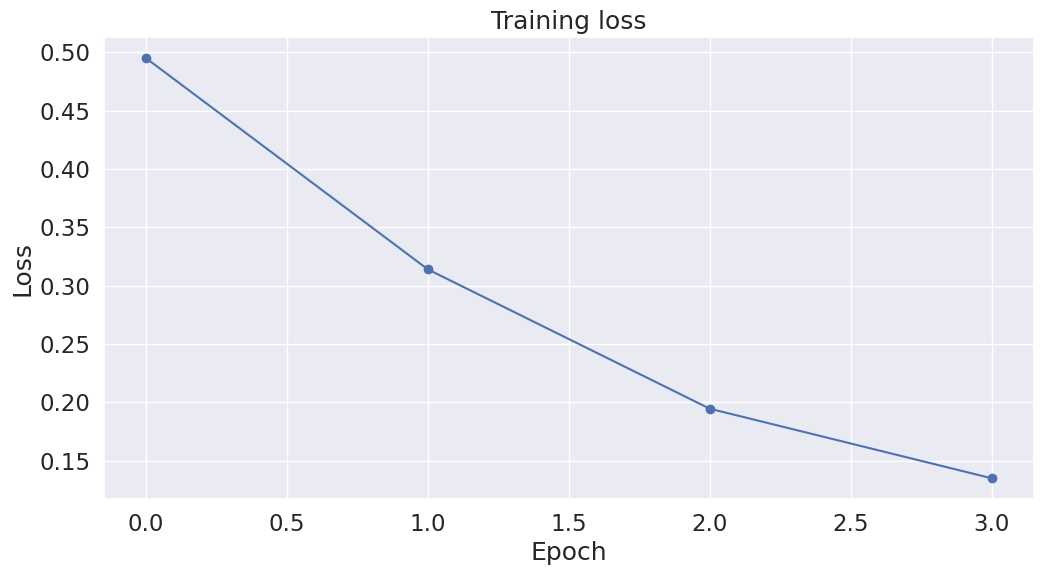

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [28]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [29]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [30]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [31]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [32]:
matthews_set

[np.float64(0.049286405809014416),
 np.float64(-0.2548235957188128),
 np.float64(0.4040950971038548),
 np.float64(0.23372319715296222),
 np.float64(0.44440090347500916),
 np.float64(0.7410010097502685),
 np.float64(0.4879500364742666),
 np.float64(-0.06788442333021306),
 np.float64(0.8320502943378436),
 np.float64(0.8246211251235321),
 np.float64(0.8459051693633014),
 np.float64(0.647150228929434),
 np.float64(0.8150678894028793),
 np.float64(0.647150228929434),
 np.float64(0.1794871794871795),
 np.float64(0.6625413488689132),
 0.0]

In [33]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.514


### 추론 코드

In [48]:
import torch

MAX_LEN = 10

def predict_with_cordic(model, tokenizer, sentence, device):
    """
    CORDIC-Softmax 패치된 model + tokenizer를 이용해
    단일 문장(sentence)에 대해 CoLA 예측을 수행합니다.
    """
    model.eval()

    # 토크나이징 + 패딩
    encoded = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    # GPU/CPU 동일하게 맞추기
    inputs = {k: v.to(device) for k, v in encoded.items()}

    # 순전파만 수행
    with torch.no_grad():
        outputs = model(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            token_type_ids=inputs.get("token_type_ids", None)
        )
        # HuggingFace 버전 따라 .logits 또는 [0]
        logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]

    # CORDIC-Softmax로 이미 변환된 attention을 쓰므로
    # classification head 출력만 softmax
    probs = torch.softmax(logits, dim=-1)    # [1, 2]
    pred  = torch.argmax(probs, dim=-1).item()

    return pred, probs.cpu().numpy().flatten()


# — 사용 예시 —
sentence = "Here is a sample sentence to test CORDIC inference."
pred, probs = predict_with_cordic(model, tokenizer, sentence, device)

label_name = "acceptable" if pred == 1 else "unacceptable"
print(f"Sentence        : {sentence}")
print(f"Predicted label : {pred} ({label_name})")
print(f"Probabilities   : [0]={probs[0]:.4f}, [1]={probs[1]:.4f}")


NameError: name 'cordic_softmax_2way' is not defined

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# 1. 모델 및 토크나이저 로드 (예: 'bert-base-uncased' 사용)
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.cuda()               # GPU로 이동
model.eval()               # 평가 모드로 전환

tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

# 2. 추론할 영어 문장 예시
sentence = "This is an example sentence for inference."

# 3. 문장 토큰화 및 인코딩
inputs = tokenizer.encode_plus(
    sentence,
    add_special_tokens=True,      # [CLS]와 [SEP] 토큰 추가
    max_length=10,                # 최대 길이 설정
    padding="max_length",         # 최대 길이에 맞춰 패딩
    truncation=True,              # 길면 잘라냄
    return_tensors="pt"           # 파이토치 텐서 반환
)

# 4. 텐서를 GPU로 이동
inputs = {key: value.to("cuda") for key, value in inputs.items()}

# 5. 추론 (forward pass)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs[0]  # 모델의 출력은 튜플이며, 첫 번째 요소가 로짓입니다.

# 6. Softmax 적용 (선택 사항) 및 예측 클래스 결정
probs = torch.softmax(logits, dim=1)
predicted_class = torch.argmax(probs, dim=1)

# 7. 결과 출력
print("입력 문장:", sentence)
print("예측된 클래스:", predicted_class.item())
print("예측 확률:", probs)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


입력 문장: This is an example sentence for inference.
예측된 클래스: 0
예측 확률: tensor([[0.7347, 0.2653]], device='cuda:0')


In [ ]:
def predict_sentence(model, tokenizer, sentence, max_length=10, device="cuda"):
    """
    입력된 문장에 대해 학습된 모델을 사용하여 예측을 수행합니다.
    Returns:
        predicted_class: 예측된 클래스 (예: 0 또는 1)
        probs: 각 클래스의 확률 (numpy 배열)
    """
    # 문장을 토큰화하고 encode_plus를 통해 [CLS], [SEP] 토큰을 추가하며, 패딩/자르기 적용
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,      # [CLS]와 [SEP] 추가
        max_length=max_length,        # 최대 길이
        padding="max_length",         # 최대 길이에 맞게 패딩
        truncation=True,              # 길면 자르기
        return_tensors="pt"           # PyTorch 텐서 반환
    )

    # GPU로 텐서를 전송
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # 모델을 평가 모드로 전환하고, 추론 시에는 기울기를 계산하지 않도록 설정
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs[0]  # 모델의 출력은 튜플 형태로, 첫 번째 요소가 logits입니다.
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class, probs.cpu().numpy()

# 예시 사용
sentence = "This is an example sentence for inference."
pred_class, pred_probs = predict_sentence(model, tokenizer, sentence)
print("입력 문장:", sentence)
print("예측된 클래스:", pred_class)
print("예측 확률:", pred_probs)


입력 문장: This is an example sentence for inference.
예측된 클래스: 0
예측 확률: [[0.73471546 0.26528448]]


### cordic 코드

In [34]:
#import numpy as np

import torch
import numpy as np

def top_1200_input(attention_scores):
    """
    1200개의 attention_scores를 120개의 리스트로 나누어 각 리스트를 top 함수에 전달
    결과는 원본 형태 (1, 12, 10, 10)로 반환
    """
    if isinstance(attention_scores, torch.Tensor):
        attention_scores = attention_scores.detach().cpu().numpy()  # ✅ detach() 추가

    batch_size, num_heads, seq_length, _ = attention_scores.shape
    result_arrays = np.zeros((batch_size, num_heads, seq_length, seq_length))

    for head in range(num_heads):
        for row in range(seq_length):
            for col in range(seq_length // 10):
                input_values = attention_scores[0, head, row, col * 10:(col + 1) * 10]
                result = top(*input_values)
                result_arrays[0, head, row, col * 10:(col + 1) * 10] = result

    # ✅ numpy -> torch 변환할 때 `.to(device)` 추가
    return torch.tensor(result_arrays, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")



import numpy as np
import torch

def float_to_fixed_point(value, int_bits=7, frac_bits=13):
    """
    실수를 32비트 Fixed-Point 바이너리로 변환하는 함수.
    - 정수부는 7비트 (Signed, 2의 보수)
    - 소수부는 13비트 (항상 양수)
    """

    # ✅ PyTorch Tensor 처리
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    # ✅ NaN 또는 Inf 값 체크 후 예외 처리
    if np.isnan(value) or np.isinf(value):
        raise ValueError(f"float_to_fixed_point() - NaN 또는 무한대 값 감지: {value}")

    # ✅ **최대/최소 값 제한 (7비트 표현 범위)**
    value = max(min(value, 63), -64)

    # ✅ 정수부와 소수부 분리
    int_part = np.floor(value).astype(int)
    frac_part = abs(value - int_part)  # 소수 부분

    # ✅ 2의 보수 변환 (음수 처리)
    if int_part < 0:
        int_part = (1 << int_bits) + int_part

    int_binary = format(int_part, f'0{int_bits}b')

    # ✅ 12비트 0 추가 (BERT 출력 형식 유지)
    int_binary = "0" * 12 + int_binary

    # ✅ 소수부 변환 (13비트)
    frac_binary = ""
    for _ in range(frac_bits):
        frac_part *= 2
        if frac_part >= 1:
            frac_binary += "1"
            frac_part -= 1
        else:
            frac_binary += "0"

    # ✅ 최종 32비트 바이너리 문자열 생성
    binary_string = int_binary + frac_binary

    # ✅ `binary_string`이 음수 값을 포함하는지 확인 후 처리
    if "-" in binary_string:
        raise ValueError(f"[ERROR] 잘못된 바이너리 문자열 변환 감지: {binary_string}")

    # ✅ 20비트 정수 변환 (부호 처리)
    fixed_binary = int(binary_string, 2)
    if value < 0:
        fixed_binary = (1 << 20) - fixed_binary  # 2의 보수 변환

    lower_20_bits = fixed_binary & 0xFFFFF  # 20비트 마스킹

    return lower_20_bits






def binary_to_decimal(binary_str):
    # 16비트 중 앞 3비트는 정수부, 뒤 13비트는 소수부
    int_part = int(binary_str[:3], 2)  # 정수부
    frac_part = int(binary_str[3:], 2) / (2 ** 13)  # 소수부를 2^13으로 나눔
    return int_part + frac_part  # 정수부와 소수부 합산

def hex_to_binary(hex_str):
    """
    16비트 헥스 값을 16비트 바이너리 문자열로 변환하는 함수

    :param hex_str: 변환할 16비트 헥스 값 (예: "1A2F" 또는 0x1A2F)
    :return: 16비트 바이너리 문자열 (예: "0001101000101111")
    """
    # hex_str가 정수형일 경우 문자열로 변환
    if isinstance(hex_str, int):
        hex_str = format(hex_str, 'X')  # 16진수 대문자로 변환

    # 16진수를 10진수로 변환 후, 16비트 이진수로 변환
    binary_str = bin(int(hex_str, 16))[2:].zfill(16)
    return binary_str

# 테스트 예제


# 테스트 예제


def top(data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10) : #20bit data

    data_11 = float_to_fixed_point(data_1)
    data_22 = float_to_fixed_point(data_2)
    data_33 = float_to_fixed_point(data_3)
    data_44 = float_to_fixed_point(data_4)
    data_55 = float_to_fixed_point(data_5)
    data_66 = float_to_fixed_point(data_6)
    data_77 = float_to_fixed_point(data_7)
    data_88 = float_to_fixed_point(data_8)
    data_99 = float_to_fixed_point(data_9)
    data_1010 = float_to_fixed_point(data_10)

    data_list = [data_11, data_22, data_33, data_44, data_55, data_66, data_77, data_88, data_99, data_1010]
    #data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    int_list = [0] * 10 #exp_int input
    exp_int_output = [0]*10 #exp_int output
    fraction_list=[0]*10 #cordic_exu input
    exp_fraction_output = [0]*10 #cordic_exu output
    exp_whole=[0]*10 #cordic_exu +cordic_int
    exp_trunc=[0]*10
    exp_accum_input=[0]*10 # accumulator input  (exponential)
    exp_accum_output=[0]*1
    x_divider = [0] * 10 #cordic diu input
    y_dividend = [0] * 10 #cordic diu input
    data_out = [0] * 10
    binary_values = [0] * 10
    int_values = [0.0] * 10
    for i in range(10):  # int part
        int_list[i] = data_list[i] >> 13
    exp_int_output[0], exp_int_output[1], exp_int_output[2], exp_int_output[3], exp_int_output[4], exp_int_output[5], exp_int_output[6], exp_int_output[7], exp_int_output[8], exp_int_output[9]=exp_int(int_list[0], int_list[1], int_list[2], int_list[3], int_list[4], int_list[5], int_list[6], int_list[7], int_list[8], int_list[9])

    for i in range(10):  # fraction part
        fraction_list[i] = (data_list[i] & 0x1FFF) << 1  # 하위 13비트를 가져오고, 뒤에 0을 추가
    exp_fraction_output[0], exp_fraction_output[1], exp_fraction_output[2], exp_fraction_output[3], exp_fraction_output[4], exp_fraction_output[5], exp_fraction_output[6], exp_fraction_output[7], exp_fraction_output[8], exp_fraction_output[9] = cordic_exu(fraction_list[0], fraction_list[1], fraction_list[2], fraction_list[3], fraction_list[4], fraction_list[5], fraction_list[6], fraction_list[7], fraction_list[8], fraction_list[9])


    for i in range(10):
       exp_whole[i] = exp_int_output[i] * exp_fraction_output[i]

    for i in range(10):
       exp_trunc[i] = (exp_whole[i] >> 14) & 0xFFFFF  # 33~14 비트를 추출 (20비트)
    for i in range(10):
       exp_accum_input[i] = (exp_trunc[i] >> 4) & 0xFFFF

    exp_accum_output[0] = cordic_accumulator(exp_accum_input[0],exp_accum_input[1],exp_accum_input[2],exp_accum_input[3],exp_accum_input[4],exp_accum_input[5],exp_accum_input[6],exp_accum_input[7],exp_accum_input[8],exp_accum_input[9])



    # denominator_sf[i]에서 18~4 비트 추출 후, 앞에 0을 붙여서 x_divider에 할당
    x_divider[0] = (exp_accum_output[0] >> 4) & 0x7FFF  # 18~4 비트를 추출 (15비트)

    for i in range(10):
    # numerator_sf[i]에서 15~4 비트 추출 후, 앞에 4개의 0을 붙여서 y_dividend에 할당
        y_dividend[i] = (exp_accum_input[i] >> 4)  # 15~4 비트를 추출 (12비트)

    data_out[0],data_out[1],data_out[2],data_out[3],data_out[4],data_out[5],data_out[6],data_out[7],data_out[8],data_out[9], = cordic_diu (x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],y_dividend[0],y_dividend[1],y_dividend[2],y_dividend[3],y_dividend[4],y_dividend[5],y_dividend[6],y_dividend[7],y_dividend[8],y_dividend[9])

    for i in range(10):
        binary_values[i] = hex_to_binary(data_out[i])
       # print(binary_values[i])

    for i in range(10):
        int_values[i] = binary_to_decimal(binary_values[i])

    return int_values[0],int_values[1],int_values[2],int_values[3],int_values[4],int_values[5],int_values[6],int_values[7],int_values[8],int_values[9]

def exp_int(data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    data_to_int = [0]*10
    int_output=[0]*10
    for i in range(10):
        # 이진수로 변환하여 signed_binary_to_int 함수에 전달
        binary_str = bin(data_list[i])[2:].zfill(7)  # 20비트 이진수 문자열로 변환
        data_to_int[i] = signed_binary_to_int(binary_str)

    i_max = max(data_to_int)
    offset=signed_binary_to_int(bin(0b0001011-i_max)[2:].zfill(7)) #offset

    for i in range(10):
        int_reg=data_to_int[i]+offset
        #print(int_reg)
        if int_reg==0 :
            int_output[i]=0b0000_0000_0000_0001_00
        elif int_reg==1 :
            int_output[i]=0b0000_0000_0000_0010_11
        elif int_reg==2 :
            int_output[i]=0b0000_0000_0000_0111_10
        elif int_reg==3 :
            int_output[i]=0b0000_0000_0001_0100_00
        elif int_reg==4 :
            int_output[i]=0b0000_0000_0011_0110_10
        elif int_reg==5 :
            int_output[i]=0b0000_0000_1001_0100_10
        elif int_reg==6 :
            int_output[i]=0b0000_0001_1001_0011_10
        elif int_reg==7 :
            int_output[i]=0b0000_0100_0100_1000_11
        elif int_reg==8 :
            int_output[i]=0b0000_1011_1010_0101_00
        elif int_reg==9 :
            int_output[i]=0b0001_1111_1010_0111_00
        elif int_reg==10 :
            int_output[i]=0b0101_0110_0000_1010_10
        elif int_reg==11 :
            int_output[i]=0b1110_1001_1110_0010_01
        else :
            int_output[i]=0

    return  int_output[0], int_output[1], int_output[2], int_output[3], int_output[4], int_output[5], int_output[6], int_output[7], int_output[8], int_output[9]


def cordic_exu (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    exp_fraction =[0]*10

    for i in range(10):
        exp_fraction[i]=  cordic_exu_pipe(data_list[i])
        #print(bin(data_list[i]))

    return exp_fraction[0], exp_fraction[1], exp_fraction[2], exp_fraction[3], exp_fraction[4], exp_fraction[5], exp_fraction[6], exp_fraction[7], exp_fraction[8], exp_fraction[9]


def cordic_exu_pipe(z_in):
    x_1, y_1, z_1=exp_unit(0b1001101010001111, 0, z_in, 0b0010001100100111,1)
    x_2, y_2, z_2=exp_unit(x_1, y_1, z_1,0b0001000001011000,2)
    x_3, y_3, z_3 = exp_unit(x_2, y_2, z_2, 0b0000100000001010, 3)
    x_4, y_4, z_4 = exp_unit(x_3, y_3, z_3, 0b0000010000000001, 4)
    x_5, y_5, z_5 = exp_unit(x_4, y_4, z_4, 0b0000001000000000, 5)
    x_6, y_6, z_6 = exp_unit(x_5, y_5, z_5, 0b0000000100000000, 6)
    x_7, y_7, z_7 = exp_unit(x_6, y_6, z_6, 0b0000000010000000, 7)
    x_8, y_8, z_8 = exp_unit(x_7, y_7, z_7, 0b0000000001000000, 8)
    x_9, y_9, z_9 = exp_unit(x_8, y_8, z_8, 0b0000000000100000, 9)
    x_10, y_10, z_10 = exp_unit(x_9, y_9, z_9, 0b0000000000010000, 10)
    x_11, y_11, z_11 = exp_unit(x_10, y_10, z_10, 0b0000000000001000, 11)
    x_12, y_12, z_12 = exp_unit(x_11, y_11, z_11, 0b0000000000000100, 12)
    x_13, y_13, z_13 = exp_unit(x_12, y_12, z_12, 0b0000000000000010, 13)
    x_14, y_14, z_14 = exp_unit(x_13, y_13, z_13, 0b0000000000000010, 14)


    exp_frac_reg=x_14+y_14
    exp_frac = (exp_frac_reg >> 1) & 0xFFFF
    #print(bin(exp_frac))
    return exp_frac



def exp_unit(x_in, y_in, z_in, lut_val, pipe_num):
    # 16-bit 입력 값
    x_cal = 0
    y_cal = 0
    z_cal = 0

    if z_in & (1 << 15):  # z_in[15] = MSB를 확인 (시계방향: z_in[15]가 1)
        # 시계방향 (downward)
        x_cal = x_in - (y_in >> pipe_num)
        y_cal = y_in - (x_in >> pipe_num)
        z_cal = z_in + lut_val
    else:
        # 반시계방향 (upward)
        x_cal = x_in + (y_in >> pipe_num)
        y_cal = y_in + (x_in >> pipe_num)
        z_cal = z_in - lut_val

    if z_cal < 0:
        # 음수일 경우 2의 보수를 구하고 16비트로 마스킹
        z_cal = (z_cal + (1 << 16)) & 0xFFFF
    else:
        z_cal = z_cal & 0xFFFF
    # 결과값 반환 (튜플로 출력)

    return x_cal, y_cal, z_cal


def signed_binary_to_int(binary_str):
    """
    2의 보수 표현된 이진수를 정수로 변환하는 함수.
    """
    # ✅ "0b" 제거
    binary_str = binary_str.replace("0b", "")

    # ✅ 이진수 길이 확인
    n = len(binary_str)

    # ✅ 부호 비트 확인 (최상위 비트가 1이면 음수)
    if binary_str[0] == '1':
        # 2의 보수 변환 (음수)
        return int(binary_str, 2) - (1 << n)
    else:
        # 양수 변환
        return int(binary_str, 2)


def accumulator(sequence_in, exponential, state):
    """
    입력값을 받아 sum1, sum2, denominator_sf 값을 업데이트하고 출력.
    """

    # accumulator_SEL 토글
    state["accumulator_SEL"] = (state["accumulator_SEL"] + sequence_in) & 1

    # valid 시프트 레지스터 갱신
    state["valid"] = [sequence_in] + state["valid"][:-1]

    if state["accumulator_SEL"]:  # accumulator 1 사용
        state["sum1"] += exponential
        if sequence_in:
            state["sum2"] = exponential  # sum2 리셋
        if state["valid"][9]:
            state["denominator_sf"] = state["sum1"]  # denominator_sf 업데이트
    else:  # accumulator 2 사용
        state["sum2"] += exponential
        if sequence_in:
            state["sum1"] = exponential  # sum1 리셋
        if state["valid"][9]:
            state["denominator_sf"] = state["sum2"]  # denominator_sf 업데이트

    sequence_out = state["valid"][0]

    return  state["denominator_sf"]


def cordic_accumulator (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    exp_fraction =[0]*10

    state_accumulator = {
    "denominator_sf": 0,
    "accumulator_SEL": 0,
    "valid": [0] * 11,
    "sum1": 0,
    "sum2": 0
}

    exp_fraction[0]=  accumulator(1,data_list[0],state_accumulator)
    exp_fraction[1]=  accumulator( 0 ,data_list[1],state_accumulator)
    exp_fraction[2]=  accumulator( 0 ,data_list[2],state_accumulator)
    exp_fraction[3]=  accumulator( 0 ,data_list[3],state_accumulator)
    exp_fraction[4]=  accumulator( 0 ,data_list[4],state_accumulator)
    exp_fraction[5]=  accumulator( 0 ,data_list[5],state_accumulator)
    exp_fraction[6]=  accumulator( 0 ,data_list[6],state_accumulator)
    exp_fraction[7]=  accumulator( 0 ,data_list[7],state_accumulator)
    exp_fraction[8]=  accumulator( 0 ,data_list[8],state_accumulator)
    exp_fraction[9]=  accumulator( 0 ,data_list[9],state_accumulator)
    #print(hex(exp_fraction[9]))

    return  exp_fraction[9]



def fifo(exponential, state):


        # FIFO 시프트 (FIFO_reg[i] = FIFO_reg[i-1])
    state["FIFO_reg"] = [exponential] + state["FIFO_reg"][:-1]

    numerator_sf = state["FIFO_reg"][9]


    return numerator_sf




def div_unit(x_in, y_in, z_in, lut_val, pipe_num):
    # 16-bit 입력 값

    y_cal = 0
    z_cal = 0

    if y_in & (1 << 15):  # z_in[15] = MSB를 확인 (시계방향: z_in[15]가 1)


        y_cal = y_in + (x_in >> pipe_num)
        z_cal = z_in - lut_val
    else:


        y_cal = y_in - (x_in >> pipe_num)
        z_cal = z_in + lut_val

    if z_cal < 0:
        # 음수일 경우 2의 보수를 구하고 16비트로 마스킹
        z_cal = (z_cal + (1 << 16)) & 0xFFFF
    else:
        z_cal = z_cal & 0xFFFF
    # 결과값 반환 (튜플로 출력)

    return  y_cal, z_cal
def cordic_diu_pipe(x_in, y_in):
    y_1, z_1 = div_unit(x_in, y_in, 0, 0b0010000000000000, 0)
    y_2, z_2 = div_unit(x_in, y_1, z_1, 0b0001000000000000, 1)
    y_3, z_3 = div_unit(x_in, y_2, z_2, 0b0000100000000000, 2)
    y_4, z_4 = div_unit(x_in, y_3, z_3, 0b0000010000000000, 3)
    y_5, z_5 = div_unit(x_in, y_4, z_4, 0b0000001000000000, 4)
    y_6, z_6 = div_unit(x_in, y_5, z_5, 0b0000000100000000, 5)
    y_7, z_7 = div_unit(x_in, y_6, z_6, 0b0000000010000000, 6)
    y_8, z_8 = div_unit(x_in, y_7, z_7, 0b0000000001000000, 7)
    y_9, z_9 = div_unit(x_in, y_8, z_8, 0b0000000000100000, 8)
    y_10, z_10 = div_unit(x_in, y_9, z_9, 0b0000000000010000, 9)
    y_11, z_11 = div_unit(x_in, y_10, z_10, 0b0000000000001000, 10)
    y_12, z_12 = div_unit(x_in, y_11, z_11, 0b0000000000000100, 11)
    y_13, z_13 = div_unit(x_in, y_12, z_12, 0b0000000000000010, 12)
    y_14, z_14 = div_unit(x_in, y_13, z_13, 0b0000000000000001, 13)
    divided_val = z_14  # Final z value representing atan(y/x)
    return divided_val

def cordic_diu (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10,data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20):
    data_list_x = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    data_list_y = [data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20]
    exp_fraction =[0]*10

    for i in range(10):
        exp_fraction[i]=  cordic_diu_pipe(data_list_x[i],data_list_y[i])
        #print(bin(data_list[i]))

    return exp_fraction[0], exp_fraction[1], exp_fraction[2], exp_fraction[3], exp_fraction[4], exp_fraction[5], exp_fraction[6], exp_fraction[7], exp_fraction[8], exp_fraction[9]


top(1.548621,
2.154268,
0.15548,
1.358942,
3.54985,
2.1578712,
-1.58952,
-0.248623,
1.6685123,
-2.68856
)



(0.0528564453125,
 0.0977783203125,
 0.0128173828125,
 0.0438232421875,
 0.3963623046875,
 0.0980224609375,
 0.0552978515625,
 0.0140380859375,
 0.0599365234375,
 0.1666259765625)

### 모델 수정 및 적용 코드

In [38]:
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention, BertEncoder, BertForSequenceClassification, BertConfig

# … (BertSelfAttentionModified / BertEncoderModified / BertWithModifiedAttentionForClassification 정의부는 그대로) …

# 4. 모델 생성
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertWithModifiedAttentionForClassification(config)

# ★ 학습시킨 가중치만 불러오기 (절대 구조 정의부는 건드리지 마세요)
checkpoint = torch.load("./model/CoLA.pt", map_location="cpu")
model.load_state_dict(checkpoint, strict=False)

# 이후 GPU 이동·평가 모드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 예시 추론 함수 (변경 없음)
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

def predict_sentence(model, tokenizer, sentence, max_length=10, device=device):
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs[0]
        probs = torch.softmax(logits, dim=1)
        pred  = torch.argmax(probs, dim=1).item()
    return pred, probs.cpu().numpy()

# 테스트
sentence = "This is a grammatically acceptable sentence."
pred_class, pred_probs = predict_sentence(model, tokenizer, sentence)
print("입력 문장:", sentence)
print("예측된 클래스:", pred_class)
print("예측 확률:", pred_probs)


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [38]:
from transformers.models.bert.modeling_bert import BertSelfAttention, BertEncoder, BertForSequenceClassification, BertConfig

# 1. BertSelfAttentionModified: 기존 softmax 대신 CORDIC 연산을 적용
class BertSelfAttentionModified(BertSelfAttention):
    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):
        mixed_query_layer = self.query(hidden_states)
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)

        # CORDIC 방식으로 softmax 대체
        cordic_attention = top_1200_input(attention_scores)
        attention_probs = torch.as_tensor(cordic_attention, dtype=torch.float32, device=hidden_states.device)

        if attention_mask is not None:
            attention_probs = attention_probs + attention_mask

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        if output_attentions:
            return (context_layer, attention_probs, attention_scores)
        else:
            return (context_layer,)

# 2. BertEncoderModified: 모든 레이어의 self-attention을 수정된 클래스로 교체
class BertEncoderModified(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        for i in range(config.num_hidden_layers):
            self.layer[i].attention.self = BertSelfAttentionModified(config)

# 3. BertWithModifiedAttentionForClassification: 최종 모델에서 커스텀 encoder 사용
class BertWithModifiedAttentionForClassification(BertForSequenceClassification):
    def __init__(self, config):
        config.num_labels = 2  # CoLA는 이진 분류 문제
        super().__init__(config)
        self.bert.encoder = BertEncoderModified(config)

# 4. 모델 생성 및 학습/추론
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertWithModifiedAttentionForClassification(config)
model.cuda()
model.eval()


BertWithModifiedAttentionForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoderModified(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttentionModified(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [39]:
class BertForSequenceClassificationModified(BertForSequenceClassification):
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)

        logits = outputs[0]

        # Softmax 대신 CORDIC을 적용
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

        return logits, probs


In [36]:
from transformers.models.bert.modeling_bert import BertSelfAttention, BertEncoder, BertForSequenceClassification, BertConfig

# 1. BertSelfAttentionModified: 기존 softmax 대신 CORDIC 연산을 적용
class BertSelfAttentionModified(BertSelfAttention):
    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):
        mixed_query_layer = self.query(hidden_states)
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)

        # 여기서 원래 softmax를 적용하는 대신 CORDIC 기반 함수를 사용합니다.
        # 예를 들어, top_1200_input(attention_scores)를 사용하여 softmax 결과를 근사합니다.
        cordic_attention = top_1200_input(attention_scores)
        # 만약 반환된 결과가 numpy 형태라면, torch.tensor로 변환해주어야 합니다.
        attention_probs = torch.as_tensor(cordic_attention, dtype=torch.float32, device=hidden_states.device)

        if attention_mask is not None:
            attention_probs = attention_probs + attention_mask

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        # 원래 출력은 (context_layer, attention_probs) 또는 (context_layer,)인데,
        # 필요에 따라 raw attention scores도 반환하도록 할 수 있습니다.
        if output_attentions:
            return (context_layer, attention_probs, attention_scores)
        else:
            return (context_layer,)

# 2. BertEncoderModified: 모든 레이어의 self-attention을 수정된 클래스로 교체
class BertEncoderModified(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        for i in range(config.num_hidden_layers):
            self.layer[i].attention.self = BertSelfAttentionModified(config)

# 3. BertWithModifiedAttentionForClassification: 최종 모델에서 커스텀 encoder 사용
class BertWithModifiedAttentionForClassification(BertForSequenceClassification):
    def __init__(self, config):
        config.num_labels = 2  # CoLA는 이진 분류 문제
        super().__init__(config)
        self.bert.encoder = BertEncoderModified(config)

# 4. 모델 생성 및 학습/추론
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertWithModifiedAttentionForClassification(config)
# 만약 학습된 가중치를 로드해야 한다면 로드합니다.
# model.load_state_dict(torch.load("your_checkpoint.pt"), strict=False)
model.cuda()
model.eval()

# 이제 이 모델은 CoLA나 다른 영어 문장 분류 작업에 사용할 수 있습니다.
# 예시 추론 함수:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
def predict_sentence(model, tokenizer, sentence, max_length=10, device="cuda"):
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs[0]
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
    return predicted_class, probs.cpu().numpy()

# 예시 문장으로 테스트
sentence = "This is a grammatically acceptable for sentence."
pred_class, pred_probs = predict_sentence(model, tokenizer, sentence)
print("입력 문장:", sentence)
print("예측된 클래스:", pred_class)
print("예측 확률:", pred_probs)


입력 문장: This is a grammatically acceptable for sentence.
예측된 클래스: 0
예측 확률: [[0.5131679  0.48683208]]


In [37]:
# 모델의 encoder 내 각 레이어의 self-attention 모듈 타입을 출력하여
# 수정된 BertSelfAttentionModified가 적용되었는지 확인합니다.
print("수정된 Attention Layers 확인:")
for i, layer in enumerate(model.bert.encoder.layer):
    attn_layer = layer.attention.self
    print(f"Layer {i} self-attention layer type: {type(attn_layer)}")


수정된 Attention Layers 확인:
Layer 0 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 1 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 2 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 3 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 4 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 5 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 6 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 7 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 8 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 9 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 10 self-attention layer type: <class '__main__.BertSelfAttentionModified'>
Layer 11 self-attention layer type: <class '__main__.BertSelfAttentionModified'>


### 디버깅용 잡동사니코드

In [ ]:
    print(f"[TOP] exp_fraction_output[{i}] = {exp_fraction_output[i]}")
    print(f"[TOP] exp_int_output[{i}] = {exp_int_output[i]}")
    print(f"[TOP] exp_whole[{i}] = {exp_whole[i]}")
    print(f"[TOP] exp_trunc[{i}] = {exp_trunc[i]}")
    print(f"[TOP] exp_accum_input[{i}] = {exp_accum_input[i]}")
    print(f"[TOP] x_divider = {x_divider[0]}")
    print(f"[TOP] y_dividend = {y_dividend[i]}")
    print(f"[TOP] data_out[{i}] = {data_out[i]}")

In [ ]:
from transformers.models.bert.modeling_bert import BertSelfAttention, BertEncoder, BertForSequenceClassification, BertConfig
import torch.nn as nn
import torch
import numpy as np

# 1. BertSelfAttentionModified: 기존 softmax 대신 CORDIC 연산을 적용
class BertSelfAttentionModified(BertSelfAttention):
    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):
        mixed_query_layer = self.query(hidden_states)
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        # ✅ 디버깅용 Q, K 체크
        with torch.no_grad():
            h = hidden_states.detach().cpu().numpy()
            print("=== Hidden States 디버깅 ===")
            print("min:", np.min(h), "max:", np.max(h))
            print("NaN 수:", np.isnan(h).sum(), "Inf 수:", np.isinf(h).sum())
            q = query_layer.detach().cpu().numpy()
            k = key_layer.detach().cpu().numpy()
            print("=== Q, K 디버깅 ===")
            print("Q min/max:", np.min(q), np.max(q))
            print("K min/max:", np.min(k), np.max(k))
            print("Q NaN 수:", np.isnan(q).sum(), "K NaN 수:", np.isnan(k).sum())
            print("Q Inf 수:", np.isinf(q).sum(), "K Inf 수:", np.isinf(k).sum())

        # attention score 계산 후 clamp
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)
        with torch.no_grad():
            print("=== [DEBUG] attention_scores 계산 직후 ===")
            print("min:", attention_scores.min().item(), "max:", attention_scores.max().item())
            print("NaN 수:", torch.isnan(attention_scores).sum().item(), "Inf 수:", torch.isinf(attention_scores).sum().item())
        attention_scores = torch.clamp(attention_scores, min=-10.0, max=10.0)

        with torch.no_grad():
            print("=== [DEBUG] attention_scores 예시 ===")
            print(attention_scores[0, 0, 0, :10])
            print("min:", attention_scores.min().item(), "max:", attention_scores.max().item())
            print("NaN 수:", torch.isnan(attention_scores).sum().item())
        # CORDIC 방식으로 softmax 대체 (임시로 softmax로 출력 확인)
        cordic_attention = top_1200_input(attention_scores)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        if attention_mask is not None:
            attention_probs = attention_probs + attention_mask

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        if output_attentions:
            return (context_layer, attention_probs, attention_scores)
        else:
            return (context_layer,)


# 2. BertLayerWithNaNCheck: layer 0 내부 모듈 NaN 추적
class BertLayerWithNaNCheck(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, hidden_states, *args, **kwargs):
        print("=== [Layer 0] BEFORE ===")
        print("min:", hidden_states.min().item(), "max:", hidden_states.max().item())
        print("NaN 수:", torch.isnan(hidden_states).sum().item(), "Inf 수:", torch.isinf(hidden_states).sum().item())

        hidden_states, *_ = self.layer.attention(hidden_states, *args, **kwargs)
        if torch.isnan(hidden_states).any():
            print("[NaN DETECTED] ❌ after Attention in Layer 0")

        intermediate_output = self.layer.intermediate(hidden_states)
        if torch.isnan(intermediate_output).any():
            print("[NaN DETECTED] ❌ after Intermediate in Layer 0")

        layer_output = self.layer.output(intermediate_output, hidden_states)
        if torch.isnan(layer_output).any():
            print("[NaN DETECTED] ❌ after Output in Layer 0")

        print("=== [Layer 0] AFTER ===")
        print("min:", layer_output.min().item(), "max:", layer_output.max().item())
        print("NaN 수:", torch.isnan(layer_output).sum().item(), "Inf 수:", torch.isinf(layer_output).sum().item())

        return (layer_output,)


# 3. BertEncoderModified
class BertEncoderModified(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        for i in range(config.num_hidden_layers):
            self.layer[i].attention.self = BertSelfAttentionModified(config)
        self.layer[0] = BertLayerWithNaNCheck(self.layer[0])

    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_values=None, use_cache=False, output_attentions=False,
                output_hidden_states=False, return_dict=True):

        for i, layer_module in enumerate(self.layer):
            with torch.no_grad():
                hs = hidden_states.detach().cpu().numpy()
                if np.isnan(hs).sum() > 0:
                    print(f"[NaN DETECTED] ❌ in hidden_states BEFORE layer {i}")
                else:
                    print(f"[OK] ✅ hidden_states BEFORE layer {i}")

            layer_outputs = layer_module(
                hidden_states,
                attention_mask,
                head_mask[i] if head_mask is not None else None,
                encoder_hidden_states,
                encoder_attention_mask,
                past_key_values[i] if past_key_values is not None else None,
                output_attentions,
            )
            hidden_states = layer_outputs[0]

        return (hidden_states,)


# 4. BertWithModifiedAttentionForClassification
class BertWithModifiedAttentionForClassification(BertForSequenceClassification):
    def __init__(self, config):
        config.num_labels = 2
        super().__init__(config)
        self.bert.encoder = BertEncoderModified(config)

# 5. Load config and model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertWithModifiedAttentionForClassification(config)
model.cuda()
model.eval()


BertWithModifiedAttentionForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoderModified(
      (layer): ModuleList(
        (0): BertLayerWithNaNCheck(
          (layer): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttentionModified(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer

def predict_sentence(model, tokenizer, sentence):
    model.eval()
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=64,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_class = np.argmax(probs)

    return pred_class, probs


In [ ]:
def check_for_nan(module, input, output):
    if isinstance(output, torch.Tensor):
        if torch.isnan(output).any():
            print(f"[NaN DETECTED] in {module.__class__.__name__}")
    elif isinstance(output, (tuple, list)):
        for o in output:
            if torch.is_tensor(o) and torch.isnan(o).any():
                print(f"[NaN DETECTED] in {module.__class__.__name__}")

for name, module in model.named_modules():
    module.register_forward_hook(check_for_nan)


In [ ]:
import torch.nn as nn
import torch

class BertLayerWithNaNCheck(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, hidden_states, *args, **kwargs):
        print("=== [Layer 0] BEFORE ===")
        print("min:", hidden_states.min().item(), "max:", hidden_states.max().item())
        print("NaN 수:", torch.isnan(hidden_states).sum().item(), "Inf 수:", torch.isinf(hidden_states).sum().item())

        # Attention
        hidden_states, *_ = self.layer.attention(hidden_states, *args, **kwargs)
        if torch.isnan(hidden_states).any():
            print("[NaN DETECTED] ❌ after Attention in Layer 0")

        # Intermediate
        intermediate_output = self.layer.intermediate(hidden_states)
        if torch.isnan(intermediate_output).any():
            print("[NaN DETECTED] ❌ after Intermediate in Layer 0")

        # Output
        layer_output = self.layer.output(intermediate_output, hidden_states)
        if torch.isnan(layer_output).any():
            print("[NaN DETECTED] ❌ after Output in Layer 0")

        print("=== [Layer 0] AFTER ===")
        print("min:", layer_output.min().item(), "max:", layer_output.max().item())
        print("NaN 수:", torch.isnan(layer_output).sum().item(), "Inf 수:", torch.isinf(layer_output).sum().item())

        return (layer_output,)


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

sentence = "The cat is sitting on the mat."
pred_class, pred_probs = predict_sentence(model, tokenizer, sentence)

print("문장:", sentence)
print("예측 클래스:", pred_class)
print("클래스별 확률:", pred_probs)


[OK] ✅ hidden_states BEFORE layer 0
=== [Layer 0] BEFORE ===
min: -4.571415901184082 max: 3.8990025520324707
NaN 수: 0 Inf 수: 0
=== Hidden States 디버깅 ===
min: -4.571416 max: 3.8990026
NaN 수: 0 Inf 수: 0
=== Q, K 디버깅 ===
Q min/max: -2.1867194 2.275151
K min/max: -2.4105966 2.2897592
Q NaN 수: 0 K NaN 수: 0
Q Inf 수: 0 K Inf 수: 0
=== [DEBUG] attention_scores 계산 직후 ===
min: -1.3686672449111938 max: 1.3171285390853882
NaN 수: 0 Inf 수: 0
=== [DEBUG] attention_scores 예시 ===
tensor([ 0.4173, -0.1602, -0.0771,  0.3595,  0.1112, -0.1229, -0.2256, -0.0283,
        -0.1147, -0.0984], device='cuda:0')
min: -1.3686672449111938 max: 1.3171285390853882
NaN 수: 0
[NaN DETECTED] ❌ after Attention in Layer 0
[NaN DETECTED] ❌ after Intermediate in Layer 0
[NaN DETECTED] ❌ after Output in Layer 0
=== [Layer 0] AFTER ===
min: nan max: nan
NaN 수: 49152 Inf 수: 0
[NaN DETECTED] ❌ in hidden_states BEFORE layer 1
=== Hidden States 디버깅 ===
min: nan max: nan
NaN 수: 49152 Inf 수: 0
=== Q, K 디버깅 ===
Q min/max: nan nan
K mi

ValueError: float_to_fixed_point() - NaN 또는 무한대 값 감지: nan

In [ ]:
from transformers.models.bert.modeling_bert import BertSelfAttention, BertEncoder, BertForSequenceClassification, BertConfig

# 1. BertSelfAttentionModified: 기존 softmax 대신 CORDIC 연산을 적용
class BertSelfAttentionModified(BertSelfAttention):
    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):
        mixed_query_layer = self.query(hidden_states)
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)
        batch_size, num_heads, seq_len, _ = attention_scores.shape
        for b in range(batch_size):
          for h in range(num_heads):
            for row in range(seq_len):
              float_row = attention_scores[b, h, row, :10].detach().cpu().numpy().tolist()

              if any(np.isnan(f) for f in float_row):
                print(f"[NaN] b={b}, head={h}, row={row} - 입력에 NaN 있음! ❌")
                continue  # 이건 skip하고 다음으로
              try:
                cordic_attention = top(*float_row)
              except Exception as e:
                print(f"[ERROR] top() 실패: {e}")


        with torch.no_grad():
          sample_row = attention_scores[0, 0, 0, :10]  # [10개 float]
          float_row = sample_row.detach().cpu().numpy().tolist()
          print("[DEBUG] top 입력값:", float_row)

          try:
            top_result = top(*float_row)
            print("[DEBUG] top 출력값:", top_result)
          except Exception as e:
            print("[ERROR] top에서 예외 발생:", e)
        # CORDIC 방식으로 softmax 대체
        cordic_attention = top(*float_row)

        if any(np.isnan(c) for c in cordic_attention):
          print(f"[NaN DETECTED] ❌ top() 결과에 NaN 존재! input: {float_row}")

        attention_probs = torch.as_tensor(cordic_attention, dtype=torch.float32, device=hidden_states.device)

        if attention_mask is not None:
            attention_probs = attention_probs + attention_mask

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        # ⚠️ 먼저 너의 원본 문장 리스트가 있어야 해!
# 예: dataset_sentences = ["문장1", "문장2", ..., "문장N"]
        # 🧪 validation_dataloader에서 원문 문장 추출 (예시)
        dataset_sentences = []

        for batch in validation_dataloader:
          input_ids = batch[0]
          for ids in input_ids:
            text = tokenizer.decode(ids, skip_special_tokens=True)
            dataset_sentences.append(text)

        for i, sentence in enumerate(dataset_sentences):
          try:
            pred_class, pred_probs = predict_sentence(model, tokenizer, sentence)
          except Exception as e:
            print(f"[❌ NaN 발생] 문장 index = {i}")
            print("문장 내용:", sentence)
            print("에러 메시지:", e)
            print("-" * 60)

        if output_attentions:
            return (context_layer, attention_probs, attention_scores)
        else:
            return (context_layer,)

# 2. BertEncoderModified: 모든 레이어의 self-attention을 수정된 클래스로 교체
class BertEncoderModified(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        for i in range(config.num_hidden_layers):
            self.layer[i].attention.self = BertSelfAttentionModified(config)

# 3. BertWithModifiedAttentionForClassification: 최종 모델에서 커스텀 encoder 사용
class BertWithModifiedAttentionForClassification(BertForSequenceClassification):
    def __init__(self, config):
        config.num_labels = 2  # CoLA는 이진 분류 문제
        super().__init__(config)
        self.bert.encoder = BertEncoderModified(config)

# 4. 모델 생성 및 학습/추론
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertWithModifiedAttentionForClassification(config)
model.cuda()
model.eval()


BertWithModifiedAttentionForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoderModified(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttentionModified(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

### 적용 모델 validation

In [42]:
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...


<ipython-input-1-b8146705381d>:34: RuntimeWarning: invalid value encountered in cast
  int_part = np.floor(value).astype(int)


ValueError: invalid literal for int() with base 2: '000000000000-1111111111111111111111111111111111111111111111111111111100000001111111111111'

In [40]:
# 가중치 저장 및 로드 코드.
path = '/content/model/'
torch.save(model.state_dict(), path+"CoLA.pt")
model.load_state_dict(torch.load(path + "CoLA.pt", map_location=device))
model.to(device)

BertWithModifiedAttentionForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoderModified(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttentionModified(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):